In [ ]:
%pip install transformers wikipedia pyvis

# The Bollywood Movie Analysis - The Final Solution

![alt text](ps.jpg)

### Agenda:
1. To analyze the gender bias in bollywood movie plots
2. Using Images, Movie plots data, find the common grounds on which gender stereotypes occur
3. Quantify the gender stereotypes by studying the demarcation of roles from Step 2
4. Suggestions to eliminate gender biases

# Step-1- Analyze gender bias in movie plots
##### Using named entity recognition, we draw relationships between the entities and their relations. It's stored in a Knowledge Base for future usage.
##### We visualize the movie plots using Knowledge Graph and identify the pitfalls in characterization of male and female characters 

In [5]:
#Import libraries for Task-1
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration
import math
import torch
import IPython
from pyvis.network import Network
import pandas as pd
import pickle

c:\Users\shree\Desktop\docu3c\Bollywood\Bollywood\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Text2Text model in case needed for regenration of movie plots
tokenizer_t5 = T5Tokenizer.from_pretrained("google/flan-t5-base")
model_t5 = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", device_map="auto")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
#Named-Entity Recognition using REBEL
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

In [8]:
#Pre-defined function, available at HuggingFace Model Card to preprocess the text and to extract enties(head, tail) and the relation between them
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [9]:
#Initilazing the Knowledge Base, contains spans of fixed sizes to accomodate for longer lengths
class Knowledge_Base():
    def __init__(self):
        self.relations = []
        self.entities = []

    def relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.relations_equal(r1, r2) for r2 in self.relations)

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_entity(self,r):
        if r["head"] not in self.entities:
            self.entities.append(r["head"])
        if r["tail"] not in self.entities:
            self.entities.append(r["tail"])

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
            self.add_entity(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")
        print("Entities")
        for e in self.entities:
            print(f"  {e}")

In [10]:
# To add the relations to KB
def from_text_to_kb(text, span_length=128, verbose=False):
    inputs = tokenizer([text], return_tensors="pt")

    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) / 
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )
    decoded_preds = tokenizer.batch_decode(generated_tokens,skip_special_tokens=False)
    kb = Knowledge_Base()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

Kabir Singh - Plot copied from wikipedia
https://en.wikipedia.org/wiki/Kabir_Singh

In [11]:
text="""Kabir Rajdheer Singh is the youngest son of wealthy business tycoon Rajdheer Singh and is studying at Delhi Institute of Medical Sciences. He has oppositional defiant personality triats with problems of severe anger management that gain him the reputation of a bully. After having a brawl against the members of the opposing team in an inter-college football match; Kabir is told to either apologise or leave, but chooses to stay upon catching sight of a new student, Preeti Sikka.
Kabir and his friends announce to the student body that Kabir has exclusively claimed Preeti. Initially timid, she adjusts to his overbearing attitude and eventually reciprocates his feelings, developing an intimate relationship with him. Kabir graduates with an MBBS degree and moves to Mussoorie for post-graduation. Despite the distance, their relationship strengthens over the next few years. After Preeti graduates, she introduces Kabir to her conservative parents, but her father Harpal catches them kissing and throws Kabir out.
Harpal continues to oppose their relationship, despite Kabir's attempts to explain their love. Enraged, Kabir demands that Preeti choose between him and her family within the next six hours, or he will end their relationship. Preeti is later unable to reach him in time; feeling abandoned, Kabir injects himself with morphine and remains unconscious for the next two days. Upon gaining consciousness, he learns that Preeti is being forced into an arranged marriage and gatecrashes the wedding party; Harpal has him beaten and arrested. After Kabir is released, his father, Rajdheer, ostracises him from the family for his antics.

With his friend Shiva’s help, Kabir finds a rented flat and joins a private hospital as a surgeon. To cope with his emotions, he abuses drugs and alcohol and names his new pet dog Preeti — none of which are successful. Within months, he becomes a successful surgeon and a high-functioning alcoholic both respected and feared by the hospital staff. His self-destructive behaviour and obsession worry his friends.

While hungover on a day off, Kabir is called in to perform an emergency surgery for which he unwillingly agrees. During the procedure, he collapses from dehydration. Suspicious, the hospital staff takes his blood samples, which contain traces of alcohol and cocaine. A case is filed against him and during an in-house hearing, a broken Kabir admits to alcoholism and violation of medical ethics. As a result, his medical licence is suspended for five years and he is evicted from his flat. The next morning, he learns of his grandmother’s death; at the funeral, he and his father reconcile. Kabir also resolves to quit his habits.

Some days later, Kabir spots a pregnant but dejected Preeti sitting in a park. He approaches and offers to raise the child with her if she is unhappy in her marriage. Initially silent, she bursts into angry tears, berates him for discarding her, and orders him to leave. Shiva then describes Kabir's obsession and self-destructive habits, which she was unaware of. Shocked, she confesses that she left her husband three days after the marriage and has been working in a clinic to support herself. Overcome with anger, especially after hearing about his casual affairs, she had refused to contact him. She reveals that her marriage was never consummated and that the child is Kabir's. They marry and reunite with their families, with Harpal apologising to them and the families coming together. The film ends showing Kabir and Preeti on a beach with their baby.

"""

GFlan with max_length fixed at 512, didn't give desired result. 
Therefore, switching over to chatgpt

In [12]:
input_text = """Consider the movie plot:
'Kabir Rajdheer Singh is the youngest son of wealthy business tycoon Rajdheer Singh and is studying at Delhi Institute of Medical Sciences. He has oppositional defiant personality triats with problems of severe anger management that gain him the reputation of a bully. After having a brawl against the members of the opposing team in an inter-college football match; Kabir is told to either apologise or leave, but chooses to stay upon catching sight of a new student, Preeti Sikka.
Kabir and his friends announce to the student body that Kabir has exclusively claimed Preeti. Initially timid, she adjusts to his overbearing attitude and eventually reciprocates his feelings, developing an intimate relationship with him. Kabir graduates with an MBBS degree and moves to Mussoorie for post-graduation. Despite the distance, their relationship strengthens over the next few years. After Preeti graduates, she introduces Kabir to her conservative parents, but her father Harpal catches them kissing and throws Kabir out.
Harpal continues to oppose their relationship, despite Kabir's attempts to explain their love. Enraged, Kabir demands that Preeti choose between him and her family within the next six hours, or he will end their relationship. Preeti is later unable to reach him in time; feeling abandoned, Kabir injects himself with morphine and remains unconscious for the next two days. Upon gaining consciousness, he learns that Preeti is being forced into an arranged marriage and gatecrashes the wedding party; Harpal has him beaten and arrested. After Kabir is released, his father, Rajdheer, ostracises him from the family for his antics.
With his friend Shiva’s help, Kabir finds a rented flat and joins a private hospital as a surgeon. To cope with his emotions, he abuses drugs and alcohol and names his new pet dog Preeti — none of which are successful. Within months, he becomes a successful surgeon and a high-functioning alcoholic both respected and feared by the hospital staff. His self-destructive behaviour and obsession worry his friends.
While hungover on a day off, Kabir is called in to perform an emergency surgery for which he unwillingly agrees. During the procedure, he collapses from dehydration. Suspicious, the hospital staff takes his blood samples, which contain traces of alcohol and cocaine. A case is filed against him and during an in-house hearing, a broken Kabir admits to alcoholism and violation of medical ethics. As a result, his medical licence is suspended for five years and he is evicted from his flat. The next morning, he learns of his grandmother’s death; at the funeral, he and his father reconcile. Kabir also resolves to quit his habits.
Some days later, Kabir spots a pregnant but dejected Preeti sitting in a park. He approaches and offers to raise the child with her if she is unhappy in her marriage. Initially silent, she bursts into angry tears, berates him for discarding her, and orders him to leave. Shiva then describes Kabir's obsession and self-destructive habits, which she was unaware of. Shocked, she confesses that she left her husband three days after the marriage and has been working in a clinic to support herself. Overcome with anger, especially after hearing about his casual affairs, she had refused to contact him. She reveals that her marriage was never consummated and that the child is Kabir's. They marry and reunite with their families, with Harpal apologising to them and the families coming together. The film ends showing Kabir and Preeti on a beach with their baby.'ArithmeticError
I want you to regenerate the plot using the following instructions:
Add the surnames, if mentioned initially, for all the characters whenever they're subsequently referred to in the plot. For example: use 'Kabir Rajdheer Singh' at every instance of Kabir, 'Preeti Sikka'  at every instance of Preeti, etc. Also, avoid pronouns like he, she, etc. and use their names(with surnames) instead. And make the plot into simple, direct sentences. for example:
instead of:
Kabir Rajdheer Singh is the youngest son of wealthy business tycoon Rajdheer Singh and is studying at Delhi Institute of Medical Sciences. He has oppositional defiant personality triats with problems of severe anger management that gain him the reputation of a bully.

make:
Kabir Rajdheer Singh is the youngest son of a wealthy business tycoon Rajdheer Singh
Kabir Rajdheer Singh is studying at Delhi Institute of Medical Sciences. 
Kabir Rajdheer Singh struggles with severe anger management issues. Kabir Rajdheer Singh gained a reputation as a bully.
"""
max_seq_length = 512

if len(tokenizer_t5.encode(input_text, add_special_tokens=True)) > max_seq_length:
    input_text = tokenizer_t5.encode(input_text, add_special_tokens=True)[:max_seq_length-1]
    input_text += [model_t5.config.eos_token_id]

input_ids = torch.tensor([input_text]).long().to(model_t5.device)
outputs = model_t5.generate(input_ids, max_length=max_seq_length, num_beams=5, early_stopping=True)
generated_seq = tokenizer_t5.decode(outputs[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (1155 > 512). Running this sequence through the model will result in indexing errors


In [13]:
generated_seq

'<pad> Kabir becomes a successful surgeon and high-functioning alcoholic both respected and feared by the hospital staff.</s>'

### Rephrasing the original plot USING gpt-3.5(ChatGPT) to construct KB:
##### Prompt:
Consider the movie plot: <the plot>
I want you to regenerate the plot using the following instructions:
Add the surnames, if mentioned initially, for all the characters whenever they're subsequently referred to in the plot. For example: use 'Kabir Rajdheer Singh' at every instance of Kabir, 'Preeti Sikka'  at every instance of Preeti, etc. Also, avoid pronouns like he, she, etc. and use their names(with surnames) instead. And make the plot into simple, direct sentences. for example:
instead of:
Kabir Rajdheer Singh is the youngest son of wealthy business tycoon Rajdheer Singh and is studying at Delhi Institute of Medical Sciences. He has oppositional defiant personality triats with problems of severe anger management that gain him the reputation of a bully.

make:
Kabir Rajdheer Singh is the youngest son of a wealthy business tycoon Rajdheer Singh
Kabir Rajdheer Singh is studying at Delhi Institute of Medical Sciences. 
Kabir Rajdheer Singh struggles with severe anger management issues. Kabir Rajdheer Singh gained a reputation as a bully.

In [241]:
chat_gpt_text="""Kabir Rajdheer Singh is the youngest son of wealthy business tycoon Rajdheer Singh. Kabir Rajdheer Singh is studying at Delhi Institute of Medical Sciences. Kabir Rajdheer Singh has problems of severe anger management that gain him the reputation of a bully.

After having a brawl against the members of the opposing team in an inter-college football match; Kabir Rajdheer Singh is told to either apologize or leave. But Kabir Rajdheer Singh chooses to stay upon catching sight of a new student, Preeti Sikka.

Kabir Rajdheer Singh and his friends announce to the student body that Kabir Rajdheer Singh has exclusively claimed Preeti Sikka. Initially timid, Preeti Sikka adjusts to Kabir Rajdheer Singh's overbearing attitude and eventually reciprocates his feelings, developing an intimate relationship with him.

Kabir Rajdheer Singh graduates with an MBBS degree and moves to Mussoorie for post-graduation. Despite the distance, their relationship strengthens over the next few years. After Preeti Sikka graduates, she introduces Kabir Rajdheer Singh to her conservative parents. Preeti Sikka's father Harpal catches them kissing and throws Kabir Rajdheer Singh out.

Harpal continues to oppose their relationship, despite Kabir Rajdheer Singh's attempts to explain their love. Enraged, Kabir Rajdheer Singh demands that Preeti Sikka choose between him and her family within the next six hours, or Kabir Rajdheer Singh will end their relationship.

Preeti Sikka is later unable to reach Kabir Rajdheer Singh in time; feeling abandoned, Kabir Rajdheer Singh injects himself with morphine and remains unconscious for the next two days. Upon gaining consciousness, Kabir Rajdheer Singh learns that Preeti Sikka is being forced into an arranged marriage and gatecrashes the wedding party. Harpal has him beaten and arrested for interrupting his daughter Preeti Sikka's marriage.

After Kabir Rajdheer Singh is released, his father, Rajdheer Singh, ostracizes him from the family for his antics. With his friend Shiva’s help, Kabir Rajdheer Singh finds a rented flat and joins a private hospital as a surgeon. To cope with his emotions, Kabir Rajdheer Singh abuses drugs and alcohol and names his new pet dog Preeti — none of which are successful.

Within months, Kabir Rajdheer Singh becomes a successful surgeon and a high-functioning alcoholic both respected and feared by the hospital staff. Kabir Rajdheer Singh's self-destructive behavior and obsession worry his friends. While hungover on a day off, Kabir Rajdheer Singh is called in to perform an emergency surgery for which he unwillingly agrees.

During the procedure, Kabir Rajdheer Singh collapses from dehydration. Suspicious, the hospital staff takes his blood samples, which contain traces of alcohol and cocaine. A case is filed against him and during an in-house hearing, a broken Kabir Rajdheer Singh admits to alcoholism and violation of medical ethics.

As a result, his medical license is suspended for five years and he is evicted from his flat. The next morning, Kabir Rajdheer Singh learns of his grandmother’s death; at the funeral, he and his father, Rajdheer Singh, reconcile. Kabir Rajdheer Singh also resolves to quit his habits.

Some days later, Kabir Rajdheer Singh spots a pregnant but dejected Preeti Sikka sitting in a park. He approaches and offers to raise the child with her if she is unhappy in her marriage. Initially silent, she bursts into angry tears, berates him for discarding her, and orders him to leave.

Shiva then describes Kabir Rajdheer Singh's obsession and self-destructive habits, which she was unaware of. Shocked, Preeti Sikka confesses that she left her husband three days after the marriage and has been working in a clinic to support herself.

Overcome with anger, especially after hearing about his casual affairs, she had refused to contact him. She reveals that her marriage was never consummated and that the child is Kabir Rajdheer Singh's. They marry and reunite with their families, with Harpal apologizing to them and the families coming together.

The film ends showing Kabir Rajdheer Singh and Preeti Sikka on a beach with their baby.

"""

In [242]:
kb_kabir = from_text_to_kb(chat_gpt_text, verbose=True)
kb_kabir.print()

Input has 989 tokens
Input has 8 spans
Span boundaries are [[0, 128], [123, 251], [246, 374], [369, 497], [492, 620], [615, 743], [738, 866], [861, 989]]
Relations:
  {'head': 'Kabir Rajdheer Singh', 'type': 'educated at', 'tail': 'Delhi Institute of Medical Sciences', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Kabir Rajdheer Singh', 'type': 'father', 'tail': 'Rajdheer Singh', 'meta': {'spans': [[0, 128], [369, 497], [738, 866]]}}
  {'head': 'Rajdheer Singh', 'type': 'child', 'tail': 'Kabir Rajdheer Singh', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Kabir Rajdheer Singh', 'type': 'residence', 'tail': 'Mussoorie', 'meta': {'spans': [[123, 251]]}}
  {'head': 'Preeti Sikka', 'type': 'spouse', 'tail': 'Kabir Rajdheer Singh', 'meta': {'spans': [[123, 251], [861, 989]]}}
  {'head': 'Kabir Rajdheer Singh', 'type': 'spouse', 'tail': 'Preeti Sikka', 'meta': {'spans': [[123, 251], [861, 989]]}}
  {'head': 'Preeti Sikka', 'type': 'father', 'tail': 'Harpal', 'meta': {'spans': [[246, 374]]}}
  {'he

In [149]:
def save_kb(kb, filename):
    with open(filename, "wb") as f:
        pickle.dump(kb, f)

In [243]:
kb_kabir.print()

Relations:
  {'head': 'Kabir Rajdheer Singh', 'type': 'educated at', 'tail': 'Delhi Institute of Medical Sciences', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Kabir Rajdheer Singh', 'type': 'father', 'tail': 'Rajdheer Singh', 'meta': {'spans': [[0, 128], [369, 497], [738, 866]]}}
  {'head': 'Rajdheer Singh', 'type': 'child', 'tail': 'Kabir Rajdheer Singh', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Kabir Rajdheer Singh', 'type': 'residence', 'tail': 'Mussoorie', 'meta': {'spans': [[123, 251]]}}
  {'head': 'Preeti Sikka', 'type': 'spouse', 'tail': 'Kabir Rajdheer Singh', 'meta': {'spans': [[123, 251], [861, 989]]}}
  {'head': 'Kabir Rajdheer Singh', 'type': 'spouse', 'tail': 'Preeti Sikka', 'meta': {'spans': [[123, 251], [861, 989]]}}
  {'head': 'Preeti Sikka', 'type': 'father', 'tail': 'Harpal', 'meta': {'spans': [[246, 374]]}}
  {'head': 'Harpal', 'type': 'religion', 'tail': 'conservative', 'meta': {'spans': [[246, 374]]}}
  {'head': 'Preeti Sikka', 'type': 'religion', 'tail': 'conser

In [244]:
filename = "network.html"
save_kb(kb_kabir, filename.split(".")[0] + ".p")
net = Network(directed=True, width="700px", height="700px", bgcolor="#eeeeee")
color_entity = "#00FF00"
for e in kb_kabir.entities:
    net.add_node(e, shape="circle", color=color_entity)
for r in kb_kabir.relations:
    net.add_edge(r["head"], r["tail"],
                    title=r["type"], label=r["type"])
net.repulsion(
        node_distance=200,
        central_gravity=0.2,
        spring_length=200,
        spring_strength=0.05,
        damping=0.09
    )
net.set_edge_smooth('dynamic')
net.show('network_kabir_singh.html',notebook=False)


network_kabir_singh.html


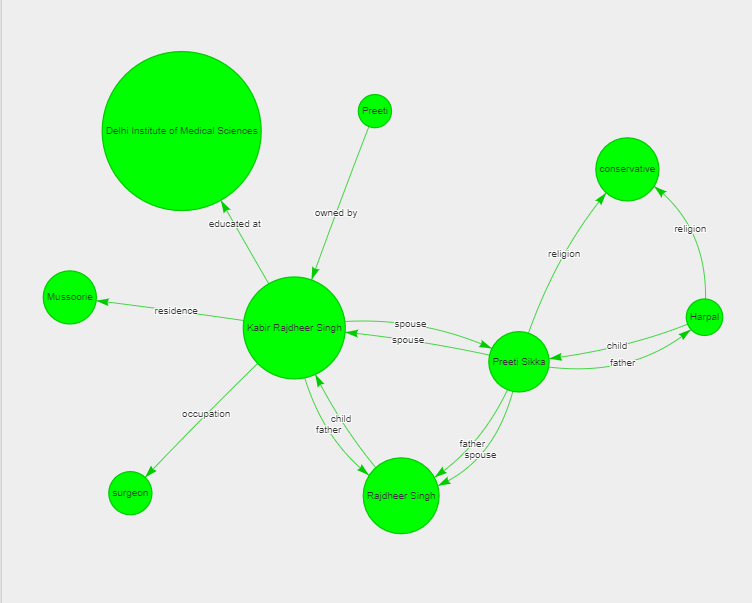
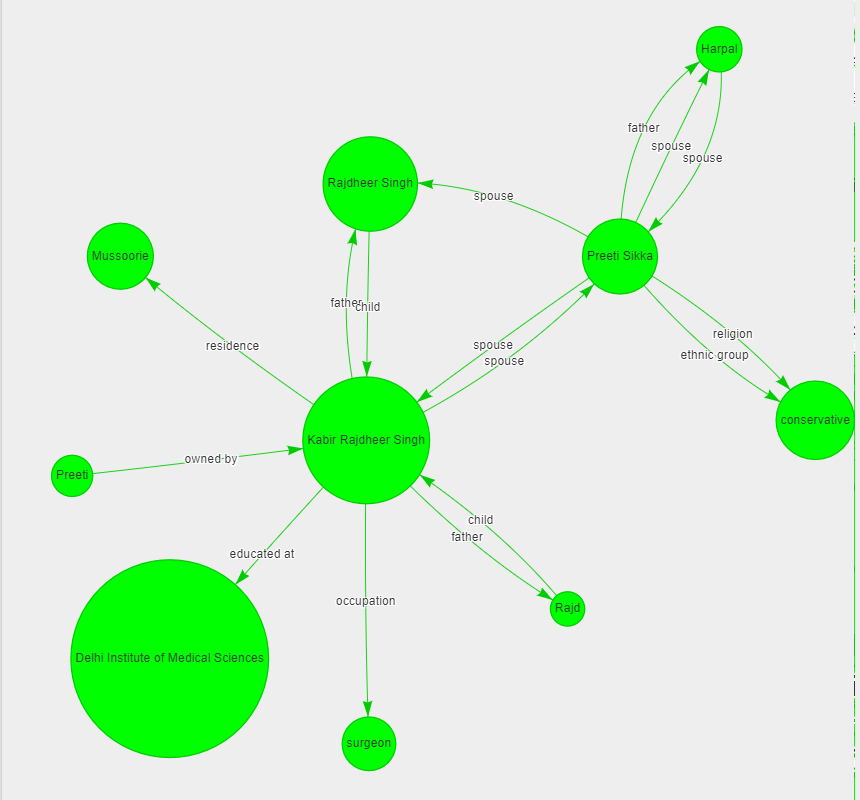

### Insights:
1. The male protagonist is depicte to have an occupation and quality education
2. His female counterpart, on the other hand is said to come from a 'conservative' family - (associated with marriage and love affairs)
3. The female protagonist lacks a strong character building and a unique identity

Animal
Plot copied from wikipedia: https://en.wikipedia.org/wiki/Animal_(2023_Indian_film)

In [152]:
text="""Vijay is the son of Balbir, a powerful Delhi-based industrialist. Despite Balbir being a strict father, Vijay's love for his father is deep and abiding. Balbir doesn't know about his son's devotion for him due to his busy schedule, which also keeps him from spending time with his family

One day, Balbir expels Vijay to a boarding school in the USA when Vijay threatens the bullies of his elder sister Reet with an AK-47. Vijay finishes his education and returns home after several years. During Balbir's birthday party, Vijay gets into an argument with his brother-in-law Varun, prompting Balbir to expel him from the house again.After his argument with Balbir, Vijay joins the European football club Real Madrid as a center forward. Vijay marries his childhood girlfriend Geetanjali from a Telugu family and the couple cuts ties with their families and moves to the USA. Eight years later, Vijay, his wife Geetanjali and their two kids return to India upon learning that Balbir had an assassination attempt. After meeting his father, Vijay reconciles with his family and takes it upon himself to uncover the assassin's identity. He rounds up his cousins from the village for backup and recruits a body double for his father, who is eventually killed by a gangster named Asrar Haque. Vijay discovers Varun's role in the assassination attempt and kills him publicly at a conference with his cousins, where Asrar Haque is also present.

Vijay and his cousins meet Freddy, an arms dealer at a hotel where Asrar Haque arrives with his assailants to kill Vijay. Vijay takes them all down with a machine gun and kills Asrar Haque, but gets severely wounded and became bedridden with a damaged sense of hearing. Vijay wakes up after two weeks and undergoes a heart transplant for his failing heart. Meanwhile, in Scotland, Asrar Haque's brother Abrar Haque learns of his death during Abrar Haque's third wedding and kills one of his men publicly at the wedding. Abrar Haque and his other brother Abid go to a house where they shoot the man who was keeping tabs on Asrar Haque revealing Abrar Haque was the one who planned the assassination attempt on Balbir. Vijay recuperates after several months and is approached by Zoya, the fiancée of his heart donor. Vijay starts an extramartial affair with Zoya. Zoya eventually reveals that she was sent by Abrar Haque to honey trap him, so that one of his brothers who transformed himself into another Vijay, would kill his family. Vijay reveals that he had already knew this and played along to learn the mastermind's identity.

    Vijay learns from his grandfather Rajdheer Singh that Abrar and his brothers are Vijay's second cousins. They are the grandchildren of Shamsher Singh, Rajdheer Singh's younger brother. Rajdheer Singh had renounced Shamsher Singh for his immoral antics. Shamsher Singh's son Azim, who had converted to Islam and married a couple of times, was denied any share in Balbir's assets, which prompted Shamsher Singh to commit suicide by setting himself on fire. Abrar Haque, who had witnessed his grandfather's suicide, became mute from the trauma. Vijay then reveals to Geetanjali about the affair with Zoya and she becomes depressed and angry at Vijay but the two put aside their differences.

Vijay with his cousins stops Abrar Haque, who is about to escape the country in a private jet with Abid. A violent fistfight ensues on the runway for a couple of hours. Vijay requests Abrar Haque to stop targeting Balbir to which he denies. At the end of the fight Vijay brutally slits Abrar's throat, thereby putting an end to the chapter.

Back in India during Diwali, Balbir reveals that he has stage 4 ALL with only a few months left to live. He realises that his lack of love for his son has always been the root cause of Vijay's aggression. Balbir finally apologises to Vijay who bitterly cries in the pain of losing his father, the one whom he loved more than anyone. At this time, Geetanjali leaves Vijay for USA with their children, but their son Abhay runs back to Vijay.

In a mid-credits scene, Aziz Haque, a butcher in Istanbul and the youngest of the Haque brothers, is revealed as the one who underwent plastic surgery to resemble another Vijay. Zoya and Abid are with him and Zoya is revealed to be pregnant, though unsure whether the child's father is Aziz or Vijay. After butchering two of Vijay's cousins brutally, Aziz sets out with Abid to exact revenge for the deaths of their two elder brothers.
"""

In [153]:
kb_animal = from_text_to_kb(text, verbose=True)
kb_animal.print()

Input has 1062 tokens
Input has 9 spans
Span boundaries are [[0, 128], [116, 244], [232, 360], [348, 476], [464, 592], [580, 708], [696, 824], [812, 940], [928, 1056]]
Relations:
  {'head': 'Balbir', 'type': 'place of birth', 'tail': 'Delhi', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Balbir', 'type': 'child', 'tail': 'Reet', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Reet', 'type': 'father', 'tail': 'Balbir', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Vijay', 'type': 'father', 'tail': 'Balbir', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Balbir', 'type': 'child', 'tail': 'Vijay', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Real Madrid', 'type': 'sport', 'tail': 'football', 'meta': {'spans': [[116, 244]]}}
  {'head': 'Vijay', 'type': 'member of sports team', 'tail': 'Real Madrid', 'meta': {'spans': [[116, 244]]}}
  {'head': 'center forward', 'type': 'sport', 'tail': 'football', 'meta': {'spans': [[116, 244]]}}
  {'head': 'Vijay', 'type': 'father', 'tail': 'his father', 'meta': {'spans': 

In [154]:
filename = "network_animal.html"
save_kb(kb_animal, filename.split(".")[0] + ".p")
net = Network(directed=True, width="700px", height="700px", bgcolor="#eeeeee")
color_entity = "#00FF00"
for e in kb.entities:
    net.add_node(e, shape="circle", color=color_entity)
for r in kb_animal.relations:
    net.add_edge(r["head"], r["tail"],
                    title=r["type"], label=r["type"])
net.repulsion(
        node_distance=200,
        central_gravity=0.2,
        spring_length=200,
        spring_strength=0.05,
        damping=0.09
    )
net.set_edge_smooth('dynamic')
net.show('network_animal.html',notebook=False)

network_animal.html


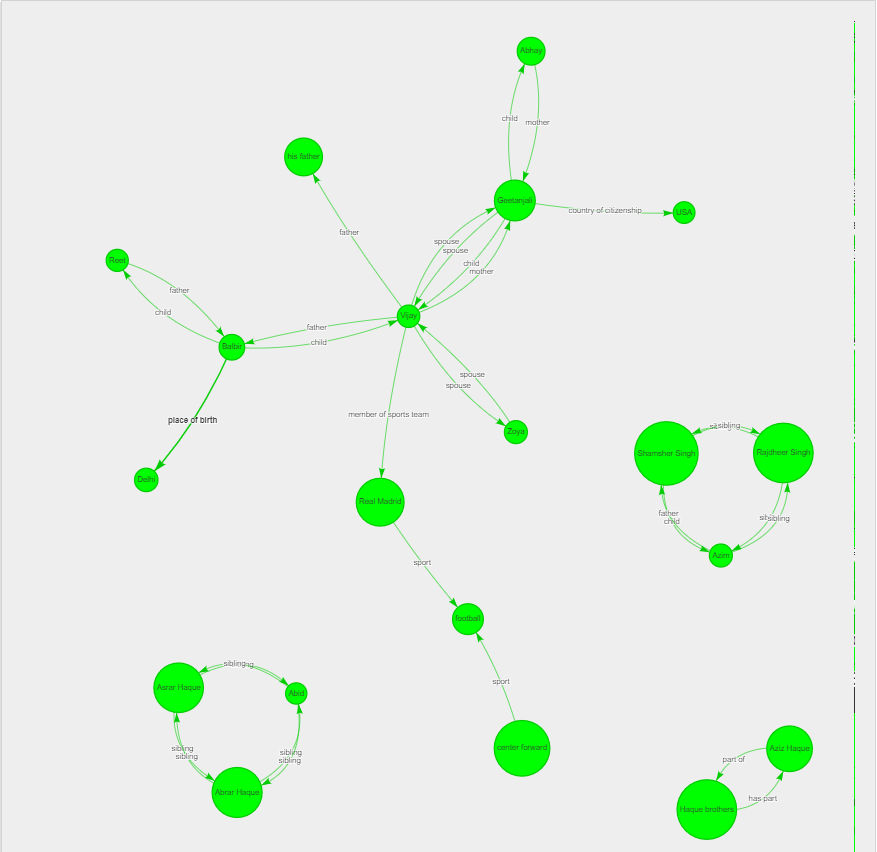
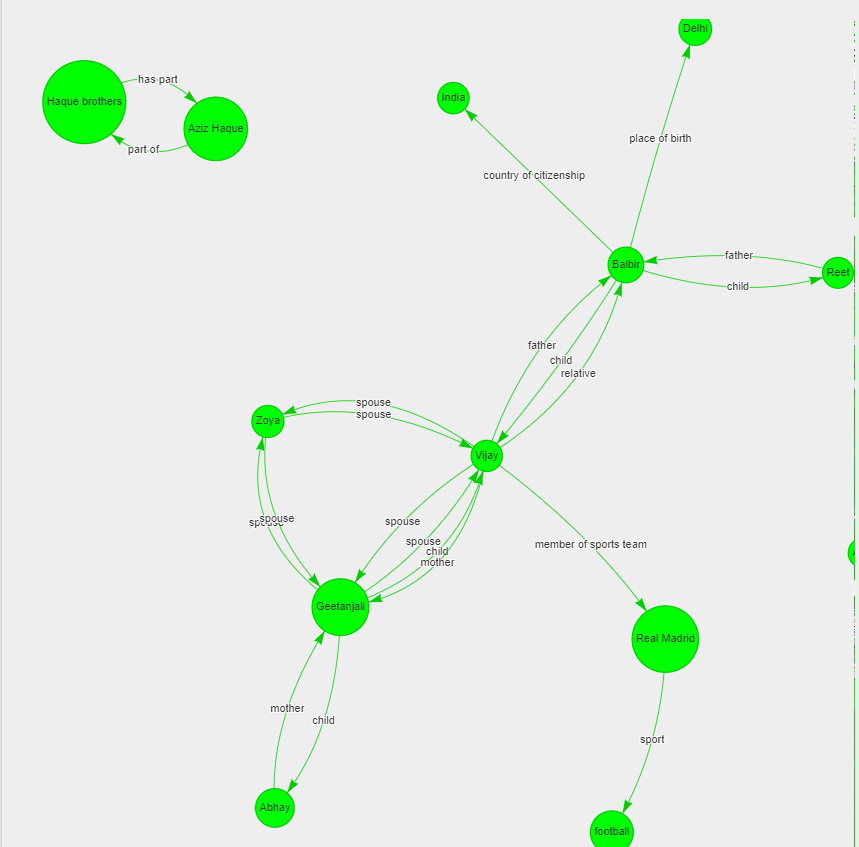

### Insights
1. A male-dominant film, where almost all the characters actively contributing to the plot are males.
2. Vijay the protagonist, is related to all the other characters in the plot. He is depicted as the member of a sports team, thus establishing his personality. The other male characters too, contribute actively to the dynamics of the movie
3. However, the only 2 female characters - Geetanjali and Zoya are depicted as merely spouses/love interests of Vijay, with no serious contribution to the plot

## Step-2 A look at the common occurence of gender bias in bollywood film plots from 1970's till 2017

In [263]:
import re
import preprocessor as p
from nltk.corpus import stopwords
from sklearn.cluster import  KMeans
import matplotlib.pyplot as plt
from wordcloud import  WordCloud
import nltk
nltk.download('stopwords')
import os
import pandas as pd
from sentence_transformers import  SentenceTransformer
embedder=SentenceTransformer('distilbert-base-nli-mean-tokens')
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shree\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
tokenizer_t5 = T5Tokenizer.from_pretrained("google/flan-t5-base")
model_t5 = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", device_map="auto")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Collecting Bollywood plots from dataset, to be used in clustering

In [192]:
df=pd.read_csv(r'C:\Users\shree\Desktop\docu3c\Bollywood\Bollywood-Data-master\wikipedia-data\coref_plot.csv')
df_female_adverbs=pd.read_csv(r'C:\Users\shree\Desktop\docu3c\Bollywood\Bollywood-Data-master\wikipedia-data\female_adjverb.csv')
df_male_adverbs=pd.read_csv(r'C:\Users\shree\Desktop\docu3c\Bollywood\Bollywood-Data-master\wikipedia-data\male_adjverb.csv')
df_female_adjective=pd.read_csv(r'C:\Users\shree\Desktop\docu3c\Bollywood\Bollywood-Data-master\wikipedia-data\female_adjectives.csv')
df_male_adjective=pd.read_csv(r'C:\Users\shree\Desktop\docu3c\Bollywood\Bollywood-Data-master\wikipedia-data\male_adjectives.csv')
df_female_verbs=pd.read_csv(r'C:\Users\shree\Desktop\docu3c\Bollywood\Bollywood-Data-master\wikipedia-data\female_verb.csv')
df_male_verbs=pd.read_csv(r'C:\Users\shree\Desktop\docu3c\Bollywood\Bollywood-Data-master\wikipedia-data\male_verb.csv')
df_female_centrality = pd.read_csv(r'C:\Users\shree\Desktop\docu3c\Bollywood\Bollywood-Data-master\wikipedia-data\female_mentions_centrality.csv')
df_male_centrality = pd.read_csv(r'C:\Users\shree\Desktop\docu3c\Bollywood\Bollywood-Data-master\wikipedia-data\male_mentions_centrality.csv')
df_image_analysis = pd.read_csv(r'C:\Users\shree\Desktop\docu3c\Bollywood\images-analysis\image_analysis.csv')


In [193]:
female_adverbs=[]
columns=list(df_female_adverbs.columns)
columns.pop(0)
len(df_female_adverbs)
for column in columns:
    for i in range(len(df_female_adverbs)):
        if pd.notna(df_female_adverbs.loc[i,column]):
            female_adverbs.append(df_female_adverbs.loc[i,column])
female_adverbs = [i for i in female_adverbs if i != '[]']
female_adverbs = [re.sub(r'[^\w\s]', '', re.sub(r'[\[\]]', '', item)).strip() for item in female_adverbs]

In [194]:
male_adverbs=[]
columns=list(df_male_adverbs.columns)
columns.pop(0)
len(df_male_adverbs)
for column in columns:
    for i in range(len(df_male_adverbs)):
        if pd.notna(df_male_adverbs.loc[i,column]):
            male_adverbs.append(df_male_adverbs.loc[i,column])
male_adverbs = [i for i in male_adverbs if i != '[]']
male_adverbs = [re.sub(r'[^\w\s]', '', re.sub(r'[\[\]]', '', item)).strip() for item in male_adverbs]

In [195]:
female_adjectives=[]
columns=list(df_female_adjective.columns)
columns.pop(0)
# len(df_female_adverbs)
for column in columns:
    for i in range(len(df_female_adjective)):
        if pd.notna(df_female_adjective.loc[i,column]):
            female_adjectives.append(df_female_adjective.loc[i,column])
female_adjectives = [i for i in female_adjectives if i != '[]']
female_adjectives = [re.sub(r'[^\w\s]', '', re.sub(r'[\[\]]', '', item)).strip() for item in female_adjectives]

In [196]:
male_adjectives=[]
columns=list(df_male_adjective.columns)
columns.pop(0)
# len(df_female_adverbs)
for column in columns:
    for i in range(len(df_male_adjective)):
        if pd.notna(df_male_adjective.loc[i,column]):
            male_adjectives.append(df_male_adjective.loc[i,column])
male_adjectives = [i for i in male_adjectives if i != '[]']
male_adjectives = [re.sub(r'[^\w\s]', '', re.sub(r'[\[\]]', '', item)).strip() for item in male_adjectives]

In [197]:
female_verbs=[]
columns=list(df_female_verbs.columns)
columns.pop(0)
for column in columns:
    for i in range(len(df_female_verbs)):
        if pd.notna(df_female_verbs.loc[i,column]):
            female_verbs.append(df_female_verbs.loc[i,column])
female_verbs = [i for i in female_verbs if i != '[]']
female_verbs = [re.sub(r'[^\w\s]', '', re.sub(r'[\[\]]', '', item)).strip() for item in female_verbs]

In [198]:
male_verbs=[]
columns=list(df_male_verbs.columns)
columns.pop(0)
# len(df_female_adverbs)
for column in columns:
    for i in range(len(df_male_verbs)):
        if pd.notna(df_male_verbs.loc[i,column]):
            male_verbs.append(df_male_verbs.loc[i,column])
male_verbs = [i for i in male_verbs if i != '[]']
male_verbs = [re.sub(r'[^\w\s]', '', re.sub(r'[\[\]]', '', item)).strip() for item in male_verbs]

In [200]:
df_image_analysis

Image Dominant Emotion Gender  Age    Race
0    36 Chowringhee Lane_img_0.jpg              sad  Woman   33   black
1              36 Ghante_img_0.jpg          neutral  Woman   25  indian
2              36 Ghante_img_0.jpg             fear  Woman   39  indian
3              36 Ghante_img_0.jpg             fear  Woman   32  indian
4              36 Ghante_img_0.jpg            angry  Woman   31  indian
..                             ...              ...    ...  ...     ...
462           Abhimanyu_img_77.jpg            happy    Man   25   white
463           Abhimanyu_img_77.jpg          disgust    Man   34   black
464           Abhimanyu_img_77.jpg            angry    Man   27   white
465           Abhimanyu_img_77.jpg              sad    Man   24  indian
466           Abhimanyu_img_77.jpg              sad    Man   30   white

[467 rows x 5 columns]

In [201]:
male_df = df_image_analysis[df_image_analysis["Gender"] == "Man"]
female_df = df_image_analysis[df_image_analysis["Gender"] == "Woman"]

# Get the list of dominant emotions for each gender
male_emotions = male_df["Dominant Emotion"].tolist()
female_emotions = female_df["Dominant Emotion"].tolist()

In [25]:
plot=''
movie=[]
all_plots=[]
for i in range(len(df)):
    if df.loc[i,'Movie Name'] in movie:
        plot+=df.loc[i,'Coref Plot'].strip()+' '
    else:
        if len(movie)!=0:
            movie.pop()
            all_plots.append(plot)
            plot=''
        movie.append(df.loc[i,'Movie Name'])
        if i==0:
            plot=df.loc[i,'Coref Plot'].strip()

In [27]:
for i in all_plots:
    if i=='':
        all_plots.remove(i)

### Generate an extensive list of Typcial Occupations assigned to men and women in bollywood movie plots. Their frequesncy is proportional to the iccurence in movies

In [28]:
# Male-Oriented Occupations
male_occupations = [
    "Policeman", "Policeman", "Policeman", "Police Officer", "Police Officer",
    "Cop", "Cop", "Cop", "Detective", "Detective",
    "Inspector", "Inspector", "Inspector", "Businessman", "Businessman",
    "Entrepreneur", "Entrepreneur", "CEO", "CEO",
    "Executive", "Executive", "Manager", "Manager",
    "Lawyer", "Lawyer", "Lawyer", "Attorney", "Attorney",
    "Advocate", "Advocate", "Legal Advisor", "Legal Advisor",
    "Solicitor", "Solicitor", "Doctor", "Doctor", "Doctor",
    "Surgeon", "Surgeon", "Physician", "Physician", "Medic",
    "Medic", "Hospital Staff", "Hospital Staff", "Engineer",
    "Engineer", "Engineer", "Mechanic", "Mechanic",
    "Technician", "Technician", "Builder", "Builder",
    "Architect", "Architect", "Soldier", "Soldier",
    "Army Officer", "Army Officer", "Commando", "Commando",
    "Warrior", "Warrior", "Military Personnel", "Military Personnel",
    "Gangster", "Gangster", "Thug", "Thug",
    "Criminal", "Criminal", "Outlaw", "Outlaw",
    "Mobster", "Mobster", "Driver", "Driver",
    "Chauffeur", "Chauffeur", "Transporter", "Transporter",
    "Courier", "Courier", "Taxi Driver", "Taxi Driver",
    "Pilot", "Pilot", "Aviator", "Aviator",
    "Airline Captain", "Airline Captain", "Flight Officer", "Flight Officer",
    "Flyer", "Flyer", "Politician", "Politician",
    "Leader", "Leader", "Minister", "Minister",
    "Government Official", "Government Official", "Public Servant", "Public Servant",
    "Journalist", "Journalist", "Reporter", "Reporter",
    "Correspondent", "Correspondent", "News Anchor", "News Anchor",
    "Media Person", "Media Person", "Professor", "Professor",
    "Teacher", "Teacher", "Educator", "Educator",
    "Instructor", "Instructor", "Lecturer", "Lecturer",
    "Singer", "Singer", "Musician", "Musician",
    "Performer", "Performer", "Artist", "Artist",
    "Entertainer", "Entertainer", "Actor", "Actor",
    "Performer", "Performer", "Artiste", "Artiste",
    "Thespian", "Thespian", "Dramatist", "Dramatist",
    "Cricketer", "Cricketer", "Sportsman", "Sportsman",
    "Athlete", "Athlete", "Batsman", "Batsman",
    "Bowler", "Bowler", "Chef", "Chef",
    "Cook", "Cook", "Culinary Artist", "Culinary Artist",
    "Kitchen Staff", "Kitchen Staff", "Food Preparer", "Food Preparer",
    "Scientist", "Scientist", "Researcher", "Researcher",
    "Lab Technician", "Lab Technician", "Inventor", "Inventor",
    "Academician", "Academician", "Bodyguard", "Bodyguard",
    "Security Personnel", "Security Personnel", "Protector", "Protector",
    "Guard", "Guard", "Bouncer", "Bouncer",
    "Hitman", "Hitman", "Assassin", "Assassin",
    "Contract Killer", "Contract Killer", "Mercenary", "Mercenary",
    "Hired Gun", "Hired Gun", "Hacker", "Hacker",
    "Computer Expert", "Computer Expert", "Cybersecurity Specialist", "Cybersecurity Specialist",
    "IT Professional", "IT Professional", "Programmer", "Programmer",
    "Mechanic", "Mechanic", "Auto Technician", "Auto Technician",
    "Car Repairman", "Car Repairman", "Garage Worker", "Garage Worker",
    "Automobile Engineer", "Automobile Engineer", "Farmer", "Farmer",
    "Agricultural Worker", "Agricultural Worker", "Rancher", "Rancher",
    "Cultivator", "Cultivator", "Grower", "Grower",
    "Carpenter", "Carpenter", "Woodworker", "Woodworker",
    "Joiner", "Joiner", "Cabinetmaker", "Cabinetmaker",
    "Construction Worker", "Construction Worker"
]

# Female-Oriented Occupations
female_occupations = [
    "Teacher", "Teacher", "Teacher", "Educator", "Educator",
    "Instructor", "Instructor", "Professor", "Professor", "Lecturer",
    "Lecturer", "Nurse", "Nurse", "Healthcare Helper", "Healthcare Helper",
    "Medical Staff", "Medical Staff", "Caregiver", "Caregiver", "Medic",
    "Medic", "Housewife", "Housewife", "Homemaker", "Homemaker",
    "Stay-at-home Mom", "Stay-at-home Mom", "Domestic Helper", "Domestic Helper",
    "Family Manager", "Family Manager", "Dancer", "Dancer", "Performer",
    "Performer", "Artist", "Artist", "Entertainer", "Entertainer",
    "Choreographer", "Choreographer", "Singer", "Singer", "Musician",
    "Musician", "Performer", "Performer", "Artist", "Artist",
    "Entertainer", "Entertainer", "Actress", "Actress", "Performer",
    "Performer", "Artiste", "Artiste", "Thespian", "Thespian",
    "Dramatist", "Dramatist", "Secretary", "Secretary", "Administrative Assistant",
    "Administrative Assistant", "Office Helper", "Office Helper", "Clerical Staff",
    "Clerical Staff", "Receptionist", "Receptionist", "Maid", "Maid",
    "Domestic Helper", "Domestic Helper", "Housekeeper", "Housekeeper",
    "Cleaning Staff", "Cleaning Staff", "Servant", "Servant",
    "Babysitter", "Babysitter", "Childcare Helper", "Childcare Helper", "Nanny",
    "Nanny", "Childminder", "Childminder", "Au Pair", "Au Pair",
    "Fashion Designer", "Fashion Designer", "Stylist", "Stylist", "Fashionista",
    "Fashionista", "Apparel Maker", "Apparel Maker", "Clothing Designer",
    "Clothing Designer", "Beautician", "Beautician", "Cosmetologist", "Cosmetologist",
    "Beauty Specialist", "Beauty Specialist", "Makeup Artist", "Makeup Artist",
    "Esthetician", "Esthetician", "Chef", "Chef", "Cook", "Cook",
    "Culinary Artist", "Culinary Artist", "Kitchen Staff", "Kitchen Staff",
    "Food Preparer", "Food Preparer", "Waitress", "Waitress", "Server",
    "Server", "Food Service Helper", "Food Service Helper", "Server", "Server",
    "Hostess", "Hostess", "Flight Attendant", "Flight Attendant", "Stewardess",
    "Stewardess", "Cabin Crew", "Cabin Crew", "Air Hostess", "Air Hostess",
    "Airline Staff", "Airline Staff", "Model", "Model", "Fashion Model",
    "Fashion Model", "Runway Model", "Runway Model", "Mannequin", "Mannequin",
    "Photo Model", "Photo Model", "Tailor", "Tailor", "Seamstress",
    "Seamstress", "Clothing Alterationist", "Clothing Alterationist", "Dressmaker",
    "Dressmaker", "Garment Helper", "Garment Helper", "Librarian", "Librarian",
    "Information Professional", "Information Professional", "Bookkeeper", "Bookkeeper",
    "Cataloguer", "Cataloguer", "Records Keeper", "Records Keeper", "Yoga Instructor",
    "Yoga Instructor", "Yogi", "Yogi", "Fitness Trainer", "Fitness Trainer",
    "Wellness Coach", "Wellness Coach", "Exercise Teacher", "Exercise Teacher",
    "Makeup Artist", "Makeup Artist", "Beauty Consultant", "Beauty Consultant",
    "Cosmetic Specialist", "Cosmetic Specialist", "Skin Care Expert", "Skin Care Expert",
    "Makeover Specialist", "Makeover Specialist", "Hairdresser", "Hairdresser", "Hairstylist",
    "Hairstylist", "Barber", "Barber", "Salon Worker", "Salon Worker",
    "Haircutter", "Haircutter", "Nutritionist", "Nutritionist", "Dietitian",
    "Dietitian", "Health Advisor", "Health Advisor", "Diet Expert",
    "Diet Expert", "Nutrition Consultant", "Nutrition Consultant", "Social Worker",
    "Social Worker", "Community Worker", "Community Worker", "Counselor",
    "Counselor", "Support Worker", "Support Worker", "Advocate", "Advocate"
]


In [29]:
for i in all_plots:
    if i=='':
        all_plots.remove(i)

In [30]:
corpus_embeddings=embedder.encode(all_plots)


In [31]:
num_clusters=2
clustering_model=KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment=clustering_model.labels_

In [32]:
cluster_df=pd.DataFrame(all_plots,columns=['plots'])
cluster_df['cluster']=cluster_assignment
cluster_df.head()

plots  cluster
0  Widowed and ailing Savitri Choudhury lives a w...        1
1  While Shekar has a mother who lives separately...        1
2  Ram is an orphan who lives with Tom aunt  Rahi...        0
3  Lucia falls in love and has an affair with Vik...        1
4  Anil and Seema become good friends through the...        1

In [33]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(all_plots[sentence_id])

In [259]:
clustered_sentences[0][:10]

["Ram is an orphan who lives with Tom aunt  Rahim lives with Tom father and horse  Tom lives with Tom father and mother very unhappilly  love the toyseller Kashi and the flower seller lady Lajjo Kashi lost Kashi wife and children in an accident and spends Kashi life with memory The story takes a turn when the smuggler Nekichand kills the side-kick and innocent Kashi was arrested for the murder But those three kids were present there As Kashi was drunk at the time of the murder Kashi can not recall anything  so Kashi never tries to defend Kashi Those three kids try to free their dear Kashi Chacha Tom 's father John fights Tom case and Ram gives witness in Tom favour Tom witness and the evidences helps in releasing innocent Kashi Ram 's aunt also comes to the court and admits that Nekichand is the killer of Ram 's father and she was trying to guard Tom as Tom is her brother When Ram comes to know that Nekichand is Nekichand father 's killer  Nekichand wants to take revenge Ultimately Nek

In [261]:
clustered_sentences[1][:10]

["Widowed and ailing Savitri Choudhury lives a wealthy lifestyle along with Savitri son  Anil  in a palatial mansion in IndiaSavitri knows that Anil is only waiting for Savitri to die so that Anil can inherit the wealth and refuses to give Anil any money The Diwan convinces Anil to mend Anil ways  get married  and patch-up with Anil mom Shortly thereafter Anil does appear to have mended Anil ways  gets involved in charity  and even introduces a young woman named Deepali to Anil mom Deepali moves in the mansion  looks after Savitri so much so that Savitri decides to make Savitri the sole beneficiary of Savitri estate What Savitri does not know is that Anil has hired Deepali to act as Anil fiancee  and that Deepali herself is not who Savitri claims to be  and is actually in love with a local horse-riding peasant  Ajit  whose father was convicted of killing Savitri 's husband  and soon Ajit Anil will be arrested by the Police for having an affair and then killing a woman named Sita ",
 "W

In [36]:
print("Cluster 1")
print(clustered_sentences[0])
print("Cluster 2")
print(clustered_sentences[1])

Cluster 1
["Ram is an orphan who lives with Tom aunt  Rahim lives with Tom father and horse  Tom lives with Tom father and mother very unhappilly  love the toyseller Kashi and the flower seller lady Lajjo Kashi lost Kashi wife and children in an accident and spends Kashi life with memory The story takes a turn when the smuggler Nekichand kills the side-kick and innocent Kashi was arrested for the murder But those three kids were present there As Kashi was drunk at the time of the murder Kashi can not recall anything  so Kashi never tries to defend Kashi Those three kids try to free their dear Kashi Chacha Tom 's father John fights Tom case and Ram gives witness in Tom favour Tom witness and the evidences helps in releasing innocent Kashi Ram 's aunt also comes to the court and admits that Nekichand is the killer of Ram 's father and she was trying to guard Tom as Tom is her brother When Ram comes to know that Nekichand is Nekichand father 's killer  Nekichand wants to take revenge Ulti

In [37]:
def word_cloud(pred_df,label):
    wc = ' '.join([text for text in pred_df['plots'][pred_df['cluster'] == label]])
    wordcloud = WordCloud(width=800, height=500,
    random_state=21, max_font_size=110).generate(wc)
    fig7 = plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

In [98]:
male_names = [
    "Muhammad", "Aarav", "Advik", "Atharv", "Vihaan", "Kiaan", "Shivansh",
    "Rishaan", "Ayansh", "Viraj", "Aryan", "Arjun", "Dhruv", "Ayaan", "Yuvaan",
    "Rudra", "Kabir", "Syed", "Madhav", "Mikayl", "Aarush", "Ryan", "Kartik",
    "Avyaan", "Nilan", "Parv", "Reyansh", "Ved", "Yug", "Parth", "Sai", "Hridaan",
    "Aaron", "Jonathan", "Ishan", "Kenan", "John", "Ali", "Joshua", "Advait",
    "Ekansh", "Avyukt", "Dev", "Viaan", "Shaurya", "Reyan", "Emmanuel", "Aaditya",
    "Rudransh", "Riyan", "Arish", "Shivaye", "Samraat", "Umar", "Shiva", "Leago",
    "Sriyansh", "Mustafa", "Rajveer", "Shivaay", "Abir", "Ridhwin", "Steve",
    "Rivaan", "Veer", "Ronan", "Yugan", "Rudhran", "Jiyansh", "Abhimanyu", "Hasan",
    "Advit", "Agastya", "David", "Akira", "Ganesh", "Anant", "Ibrahim", "Anas",
    "Ansh", "Arham", "Dakshan", "Zayn", "Ashwath", "Ethan", "Harsh", "Avik",
    "James", "Aahil", "Johan", "Keshav", "Krishiv", "Caiden", "Adhrit", "Yakshit",
    "Naitik", "Vardaan", "Namit", "Elijah", 'Vijay', 'Krishna', 'Shankar', 'Samir', 'Anand',
    'Vicky', 'Suraj', 'Rohit', 'Ravi', 'Sanjay', 'Raju', 'Shankar', 'Arun', 'Rohit', 'Vishal', 'Amar',
    'ANAND', 'KABIR', 'JAI', 'Amar', 'Ravi','Singh','Raj','rohan','ram','rahul','vikram','karan','ajay','sameer','ashok','raghu','khan','aditya','rama','sekhar','prem','kumar','ranvir',"kishan","munna","mohan","mohit","roshan","rakesh","baadshah","deepak"]

female_names = [
    "Aadhya", "Aanya", "Aarna", "Advika", "Prisha", "Amyra", "Inaya", "Pari",
    "Siya", "Kyra", "Dhriti", "Kiara", "Ananya", "Anika", "Aaradhya", "Anvi",
    "Myra", "Avni", "Riya", "Ishita", "Anaya", "Sara", "Aria", "Ananya", "Aisha",
    "Navya", "Tara", "Aarohi", "Ishani", "Roshni", "Ayesha", "Kavya", "Anjali",
    "Sneha", "Pooja", "Ritu", "Meera", "Simran", "Neha", "Rani", "Jasmine", "Maya",
    "Sakshi", "Riya", "Sanya", "Zara", "Alisha", "Aarushi", "Asha", "Nisha", "Rina",
    "Kiran", "Suman", "Savita", "Geeta", "Sita", "Lakshmi", "Radha", "Kavita",
    "Preeti", "Rukmini", "Saraswati", "Indira", "Kamala", "Parvati", "Vidya",
    "Chitra", "Anita", "Rashmi", "Priya", "Shalini", "Anjali", "Roshni", "Sheetal",
    "Rajni", "Sarita", "Savita", "Vandana", "Sunita", "Sarla", "Sangeeta", "Rekha",
    "Neelam", "Manju", "Kusum", "Kiran", "Suman", "Savita", "Geeta", "Sita",
    "Lakshmi", "Radha", "Kavita", "Preeti", "Rukmini", "Saraswati", "Indira",
    "Kamala", "Parvati", "Vidya", "Chitra", "Anita", "Rashmi", "Priya", "Shalini", "Savitri",
    "Ragini", "Veera", "Jaya", "Sameera", "Sonia", "Gayatri", "Chand", "Anandi","chandni","ganga"
    "Priya", "Pooja", "Sonia", "Geeta"
]

In [99]:
for i in range(len(male_names)):
    male_names[i]=male_names[i].lower()

for i in range(len(female_names)):
    female_names[i]=female_names[i].lower()

In [234]:
extra_stop_words=["make","will","come","take","become","back","decide","life","gets","soon","leave","time","home","start","meanwhile","keep","end","fall","accept","now","agree",
                  "make", "will", "come", "take", "become", "back", "decide", "life", "gets", "soon",
    "leave", "time", "home", "start", "meanwhile", "keep", "end", "fall", "accept", "now",
    "agree", "find", "go", "finds", "going", "gone", "went", "think", "thinks", "thought",
    "know", "knows", "knew", "see", "sees", "saw", "saying", "want", "wants", "wanted",
    "wanting", "look", "looks", "looked", "trying", "like", "likes", "liked", "loving","love","loves","loved",
    "feel", "feels", "felt", "feeling", "need", "needs", "needed", "needing", "bring",
    "brings", "brought", "bringing", "start", "starts", "starting", "end", "ends", "ended",
    "ending", "turn", "turns", "turned", "turning", "let", "lets", "letting", "mean", "means",
    "meant", "meaning", "understand", "understands", "understood", "understanding", "watch",
    "watches", "watched", "watching", "tell", "tells", "told", "telling", "hear", "hears",
    "heard", "hearing", "listen", "listens", "listened", "listening", "ask", "asks", "asked",
    "asking", "answer", "answers", "answered", "answering", "wait", "waits", "waited", "waiting",
    "arrive", "arrives", "arrived", "arriving", "do", "does", "doing", "would", "could", "should","tells","finds","meets","asks",
    "may", "might", "must", "shall", "can", "ought", "used", "use", "using", "says", "saw", "seen","gets","comes","tells",
    "goes", "finds", "find", "knows", "see", "sees", "says", "say", "come", "comes", "came","finds","tells","comes","gets","decides",
    "go", "goes", "went", "do", "did", "doing", "would", "could", "should", "may", "might","takes","much","many","able","shows","uses","informs","manages","lives",
    "must", "shall", "will", "can", "ought", "used", "use", "using", "mean", "meant", "meaning","gives","falls","give","fall","try","tries","realises","realizes",
    "feel", "felt", "feeling", "need", "needed", "needing", "come", "comes", "came", "go","refuses","calls","returns","plan","refuse","return","call","plans","decide","decides",
    "goes", "went", "make", "made", "making", "made", "turn", "turned", "turning", "turn","meet","meets",
    "turned", "turning", "let", "letting", "let", "letting", "mean", "meaning","one","another","leaves","train","new","due","do","live","makes","agree","agrees","plan","two","three","four","S","RETURN","realise","thing","continue"
]

In [229]:
def remove_stopwords(sentence):
    stop_words = set(stopwords.words('english'))
    stop_words.update(extra_stop_words)
    stop_words.update(male_names)
    stop_words.update(female_names)
    word_tokens = nltk.word_tokenize(sentence)
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_sentence)

cluster_df['plots'] = cluster_df['plots'].apply(remove_stopwords)


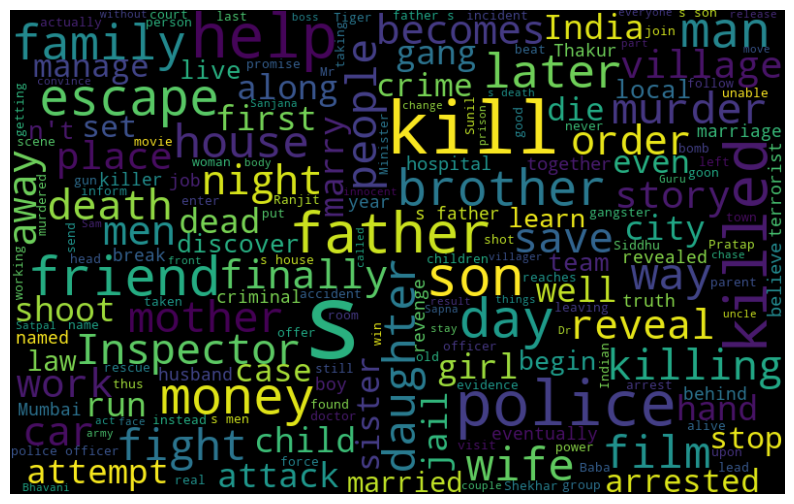

In [236]:
word_cloud(cluster_df,0)

male-oriented: kill, money, wife, fight,father, attack, murder, police, inspector, car, shoot,'man','escape',save,son

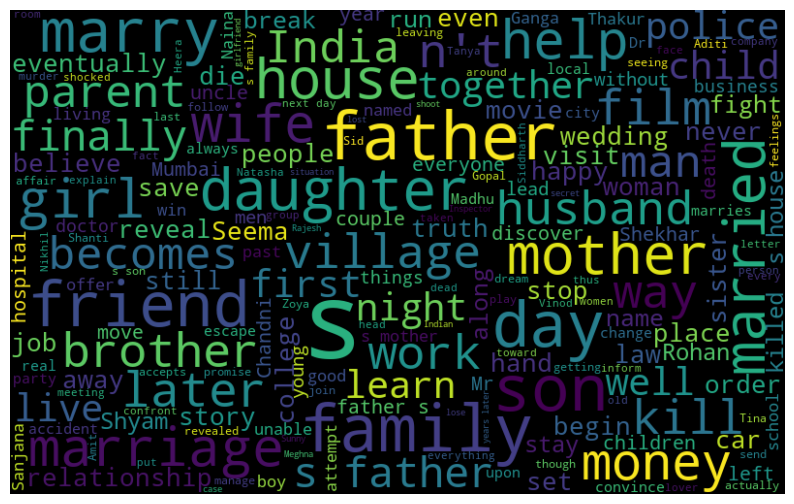

In [237]:
word_cloud(cluster_df,1)

female_related: married, family, money, husband, daughter, wife, house, help,father

In [203]:
female_oriented=female_adverbs+female_adjectives+female_verbs+female_emotions+female_occupations
male_oriented = male_adverbs+male_adjectives+male_verbs+male_emotions+male_occupations

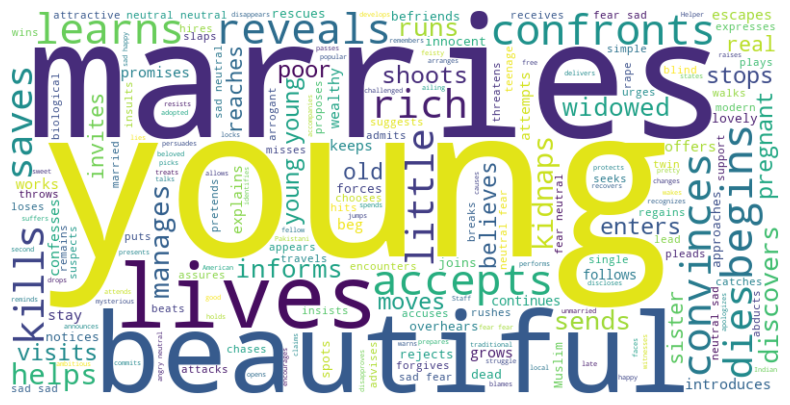

In [230]:
female_bias_wordcloud= ' '.join(female_oriented)
female_bias_wordcloud=remove_stopwords(female_bias_wordcloud)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(female_bias_wordcloud)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

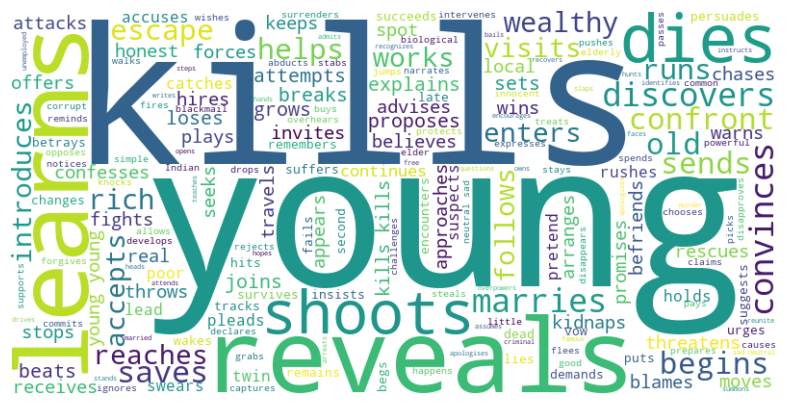

In [235]:
male_bias_wordcloud= ' '.join(male_oriented)
male_bias_wordcloud=remove_stopwords(male_bias_wordcloud)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(male_bias_wordcloud)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Step-3 To quantify the gender sterotypes based on demarcation of roles in terms of 'induviduality', 'personality', 'occupation'
The words used as a basis are from Step-2 and from prompts implemented in GPT-3.5 (ChatGPT)

In [126]:
#To identify male and female characters draw relations between entities 
import spacy
from gliner_spacy.pipeline import GlinerSpacy

In [128]:
nlp = spacy.load("en_core_web_md")
nlp.add_pipe("gliner_spacy",config={"labels":["female character","male character","female character description","male character description"]})

c:\Users\shree\Desktop\docu3c\Bollywood\Bollywood\Lib\site-packages\transformers\convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [134]:
chat_gpt_text="""Kabir is the youngest son of wealthy business tycoon Rajdheer. Kabir is studying at Delhi Institute of Medical Sciences. Kabir has problems of severe anger management that gain him the reputation of a bully.
After having a brawl against the members of the opposing team in an inter-college football match; Kabir is told to either apologize or leave. But Kabir chooses to stay upon catching sight of a new student, Preeti.
Kabir and his friends announce to the student body that Kabir has exclusively claimed Preeti. Initially timid, Preeti adjusts to Kabir's overbearing attitude and eventually reciprocates his feelings, developing an intimate relationship with him.
Kabir graduates with an MBBS degree and moves to Mussoorie for post-graduation. Despite the distance, their relationship strengthens over the next few years. After Preeti graduates, she introduces Kabir to her conservative parents. Preeti's father Harpal catches them kissing and throws Kabir out.
Harpal continues to oppose their relationship, despite Kabir's attempts to explain their love. Enraged, Kabir demands that Preeti choose between him and her family within the next six hours, or Kabir will end their relationship.
Preeti is later unable to reach Kabir in time; feeling abandoned, Kabir injects himself with morphine and remains unconscious for the next two days. Upon gaining consciousness, Kabir learns that Preeti is being forced into an arranged marriage and gatecrashes the wedding party; Harpal has him beaten and arrested.
After Kabir is released, his father, Rajdheer, ostracizes him from the family for his antics. With his friend Shiva’s help, Kabir finds a rented flat and joins a private hospital as a surgeon. To cope with his emotions, Kabir abuses drugs and alcohol and names his new pet dog Preeti — none of which are successful.
Within months, Kabir becomes a successful surgeon and a high-functioning alcoholic both respected and feared by the hospital staff. Kabir's self-destructive behavior and obsession worry his friends. While hungover on a day off, Kabir is called in to perform an emergency surgery for which he unwillingly agrees.
During the procedure, Kabir collapses from dehydration. Suspicious, the hospital staff takes his blood samples, which contain traces of alcohol and cocaine. A case is filed against him and during an in-house hearing, a broken Kabir admits to alcoholism and violation of medical ethics.
As a result, his medical license is suspended for five years and he is evicted from his flat. The next morning, Kabir learns of his grandmother’s death; at the funeral, he and his father, Rajdheer, reconcile. Kabir also resolves to quit his habits.
Some days later, Kabir spots a pregnant but dejected Preeti sitting in a park. He approaches and offers to raise the child with her if she is unhappy in her marriage. Initially silent, she bursts into angry tears, berates him for discarding her, and orders him to leave.
Shiva then describes Kabir's obsession and self-destructive habits, which she was unaware of. Shocked, Preeti confesses that she left her husband three days after the marriage and has been working in a clinic to support herself.
Overcome with anger, especially after hearing about his casual affairs, she had refused to contact him. She reveals that her marriage was never consummated and that the child is Kabir's. They marry and reunite with their families, with Harpal apologizing to them and the families coming together.
The film ends showing Kabir and Preeti on a beach with their baby.
"""

In [138]:
def split_paragraph_into_sentences(paragraph):
  sentences = []
  for sentence in paragraph.split("."):
    sentences.append(sentence.strip())
  return sentences

In [139]:
plot_sentences=split_paragraph_into_sentences(chat_gpt_text)

In [141]:
total_sentiment=[]
for sentence in plot_sentences:    
    doc=nlp(chat_gpt_text)
    dictionary=dict()
    for ent in doc.ents:
        if ent.label_ in dictionary:
            dictionary[ent.text].append(ent.label_)
        else:
            dictionary[ent.text] = [ent.label_]
    total_sentiment.append(dictionary)
    

In [143]:
total_sentiment

[{'Kabir': ['female character'],
  'bully': ['male character description'],
  'Preeti': ['male character'],
  'Harpal': ['male character'],
  'Shiva': ['male character'],
  'Rajdheer': ['female character']},
 {'Kabir': ['female character'],
  'bully': ['male character description'],
  'Preeti': ['male character'],
  'Harpal': ['male character'],
  'Shiva': ['male character'],
  'Rajdheer': ['female character']},
 {'Kabir': ['female character'],
  'bully': ['male character description'],
  'Preeti': ['male character'],
  'Harpal': ['male character'],
  'Shiva': ['male character'],
  'Rajdheer': ['female character']},
 {'Kabir': ['female character'],
  'bully': ['male character description'],
  'Preeti': ['male character'],
  'Harpal': ['male character'],
  'Shiva': ['male character'],
  'Rajdheer': ['female character']},
 {'Kabir': ['female character'],
  'bully': ['male character description'],
  'Preeti': ['male character'],
  'Harpal': ['male character'],
  'Shiva': ['male character'

### However, Gliner SPACY Failed to recognise Indian names and assign proper genders

In [ ]:
chat_gpt_text="""Kabir Rajdheer Singh is the youngest son of wealthy business tycoon Rajdheer Singh. Kabir Rajdheer Singh is studying at Delhi Institute of Medical Sciences. Kabir Rajdheer Singh has problems of severe anger management that gain him the reputation of a bully. After having a brawl against the members of the opposing team in an inter-college football match; Kabir Rajdheer Singh is told to either apologize or leave. But Kabir Rajdheer Singh chooses to stay upon catching sight of a new student, Preeti Sikka.

Kabir Rajdheer Singh and his friends announce to the student body that Kabir Rajdheer Singh has exclusively claimed     . Initially timid, Preeti Sikka adjusts to Kabir Rajdheer Singh's overbearing attitude and eventually reciprocates his feelings, developing an intimate relationship with him.

Kabir Rajdheer Singh graduates with an MBBS degree and moves to Mussoorie for post-graduation. Despite the distance, their relationship strengthens over the next few years. After Preeti Sikka graduates, she introduces Kabir Rajdheer Singh to her conservative parents. Preeti Sikka's father Harpal catches them kissing and throws Kabir Rajdheer Singh out.

Harpal continues to oppose their relationship, despite Kabir Rajdheer Singh's attempts to explain their love. Enraged, Kabir Rajdheer Singh demands that Preeti Sikka choose between him and her family within the next six hours, or Kabir Rajdheer Singh will end their relationship.

Preeti Sikka is later unable to reach Kabir Rajdheer Singh in time; feeling abandoned, Kabir Rajdheer Singh injects himself with morphine and remains unconscious for the next two days. Upon gaining consciousness, Kabir Rajdheer Singh learns that Preeti Sikka is being forced into an arranged marriage and gatecrashes the wedding party; Harpal has him beaten and arrested.

After Kabir Rajdheer Singh is released, his father, Rajdheer Singh, ostracizes him from the family for his antics. With his friend Shiva’s help, Kabir Rajdheer Singh finds a rented flat and joins a private hospital as a surgeon. To cope with his emotions, Kabir Rajdheer Singh abuses drugs and alcohol and names his new pet dog Preeti — none of which are successful.

Within months, Kabir Rajdheer Singh becomes a successful surgeon and a high-functioning alcoholic both respected and feared by the hospital staff. Kabir Rajdheer Singh's self-destructive behavior and obsession worry his friends. While hungover on a day off, Kabir Rajdheer Singh is called in to perform an emergency surgery for which he unwillingly agrees.

During the procedure, Kabir Rajdheer Singh collapses from dehydration. Suspicious, the hospital staff takes his blood samples, which contain traces of alcohol and cocaine. A case is filed against him and during an in-house hearing, a broken Kabir Rajdheer Singh admits to alcoholism and violation of medical ethics.

As a result, his medical license is suspended for five years and he is evicted from his flat. The next morning, Kabir Rajdheer Singh learns of his grandmother’s death; at the funeral, he and his father, Rajdheer Singh, reconcile. Kabir Rajdheer Singh also resolves to quit his habits.

Some days later, Kabir Rajdheer Singh spots a pregnant but dejected Preeti Sikka sitting in a park. He approaches and offers to raise the child with her if she is unhappy in her marriage. Initially silent, she bursts into angry tears, berates him for discarding her, and orders him to leave.
Shiva then describes Kabir Rajdheer Singh's obsession and self-destructive habits, which she was unaware of. Shocked, Preeti Sikka confesses that she left her husband three days after the marriage and has been working in a clinic to support herself.
Overcome with anger, especially after hearing about his casual affairs, she had refused to contact him. She reveals that her marriage was never consummated and that the child is Kabir Rajdheer Singh's. They marry and reunite with their families, with Harpal apologizing to them and the families coming together. The film ends showing Kabir Rajdheer Singh and Preeti Sikka on a beach with their baby.
"""

## Hence, we Manually assign Male and Female characters

In [163]:
male_characters=['Kabir Rajdheer Singh','Rajdheer Singh','Harpal','Shiva']
female_characters=['Preeti Sikka']
male_protagonists=['Kabir Rajdheer Singh']
female_protagonists=['Preeti Sikka']

In [145]:
characters=male_characters+female_characters

### 2 Dictionaries are initialized:
1. Role: the relation the character has with respect to other characters
2. depiction: the relation the character has with respect to other entities. These give an idea about the personality and background of the chracter we're considering

In [252]:
description={'Male Character':[],'Female Character':[]}
role={'Male Character':[],'Female Character':[]}
for i in kb_kabir.relations:
    if i['head'] in male_characters and i['tail'] not in characters:
        description['Male Character'].append({i['type']:i['tail']})
    if i['head'] in female_characters and i['tail'] not in characters:
        description['Female Character'].append({i['type']:i['tail']})
    if i['head'] in male_characters and i['tail'] in characters:
        role['Male Character'].append(i['type'])
    if i['head'] in female_characters and i['tail'] in characters:
        role['Female Character'].append(i['type'])


In [253]:
role

{'Male Character': ['father', 'child', 'spouse', 'child'],
 'Female Character': ['spouse', 'father', 'father', 'spouse']}

In [254]:
description

{'Male Character': [{'educated at': 'Delhi Institute of Medical Sciences'},
  {'residence': 'Mussoorie'},
  {'religion': 'conservative'},
  {'occupation': 'surgeon'}],
 'Female Character': [{'religion': 'conservative'}]}

### Based on the wordcloud performed previously as well as from GPT-3.5, We assign typical gender roles, seen in bollywood movies
1. Individuality: suggests whether the character has an induvidual identity.
2. Occupation: determines whether independent, qualified occupation 
3. Personality: characterizations

In [258]:
female_aspects = [ 
    {'verbs':['caring', 'compassionate', 'affectionate', 'sensitive', 'gentle', 'pure',]},
    {'individuality':['homemaker', 'supportive','marry','marrying','widowed','dependent', 'subservient','daughter of','wife of']},
    {'personality':['religious', 'pious', 'chaste', 'pretty', 'beautiful', 'fragile', 'delicate', 'weak', 'vulnerable', 'passive', 'emotional', 'nurturing','graceful', 'soft-spoken', 'shy', 'modest', 'traditional','innocent','devoted', 'self-sacrificing', 'obedient', 'compliant', 'loyal', 'sacrificial', 'adorable','feminine', 'vain', 'manipulative', 'seductive', 'temptress', 'damsel', 'victim', 'ornamental','tender', 'victimized', 'glamorous', 'dainty', 'angelic', 'maternal', 'motherly', 'matronly','conservative']}
]
male_aspects = [
    {'individuality':['occupation', 'profession', 'career', 'ambition', 'educated','self-sufficient','inspirational', 'successful', 'wealthy','influential']}, 
    {'profession':['business','sports','police','inspector', 'entrepreneur','surgeon']},
    {'personality':['leader', 'provider','strong', 'powerful', 'assertive', 'independent', 'confident', 'rational', 'logical','dominant', 'adventurous', 'brave', 'daring', 'competitive', 'resilient', 'decisive','ambitious', 'resourceful', 'innovative', 'creative', 'intellectual','knowledgeable', 'skilled', 'talented', 'responsible', 'authoritative','protagonist', 'protector', 'problem-solver', 'risk-taker', 'charismatic', 'charming','charismatic', 'determined', 'disciplined','fearless', 'heroic', 'honorable', 'loyal', 'fair', 'principled']},
    {'verbs':['kills','violent','shoot','murder','violent','aggressive','arrogant']}]

### We identify keys and values from the depiction dictionary that aligns with the words(share same/similar meaning) coming under male_aspects and female_aspects. This similarity in meaning is estimated by the cosine similarity. For values above 0.75, the score is updated by incrementation by 1.

In [304]:
male_stereotype_score={'individuality':0,'profession':0,'personality':0,'verbs':0}
female_stereotype_score={'individuality':0,'profession':0,'personality':0,'verbs':0}
to_neutralize_male=[]
to_neutralize_female=[]
threshold = 0.75
for i, j in description.items():
    if i=='Male Character':
        for dic in j:
            for dic_key,dic_val in dic.items():
                for types in male_aspects:
                    for topic,stereotypes in types.items():
                        for stereotype in stereotypes:
                            word_vector=nlp(stereotype).vector
                            story_key_embedding=nlp(dic_key).vector
                            story_val_embedding=nlp(dic_val).vector
                            similarity1=cosine_similarity([story_key_embedding], [word_vector])[0][0]
                            similarity2=cosine_similarity([story_val_embedding], [word_vector])[0][0]
                            if similarity1>threshold:
                                male_stereotype_score[topic]+=1
                                to_neutralize_female.append([dic_key,topic])
                            if similarity2>threshold:
                                male_stereotype_score[topic]+=1
                                to_neutralize_female.append([dic_key,topic])
    if i=='Female Character':
        for dic in j:
            for dic_key,dic_val in dic.items():
                for types in female_aspects:
                    for topic,stereotypes in types.items():
                        for stereotype in stereotypes:
                            word_vector=nlp(stereotype).vector
                            story_key_embedding=nlp(dic_key).vector
                            story_val_embedding=nlp(dic_val).vector
                            similarity1=cosine_similarity([story_key_embedding], [word_vector])[0][0]
                            similarity2=cosine_similarity([story_val_embedding], [word_vector])[0][0]
                            if similarity1>threshold:
                                female_stereotype_score[topic]+=1
                                to_neutralize_male.append([dic_key,topic])
                            if similarity2>threshold:
                                female_stereotype_score[topic]+=1
                                to_neutralize_male.append([dic_key,topic])

In [293]:
male_stereotype_score

{'individuality': 1, 'profession': 0, 'personality': 0, 'verbs': 0}

In [294]:
female_stereotype_score

{'individuality': 0, 'profession': 0, 'personality': 2, 'verbs': 0}

In [295]:
to_neutralize_male

[['religion', 'personality'], ['religion', 'personality']]

In [296]:
to_neutralize_female

[['occupation', 'individuality']]

### However, not all such instances indicate gender bias.
For example, if we have a businessman as well as a businesswoma in the plot, it doesn't indicate gender bias since equal representation is prevalent. 
In order to avoid misclassification in such instances, we introduce to_neutralize_male and to_neutralize_female lists, to which words are added whenever any stereotype is detected.
Once it's known that it's a gender-neutral word in that particular context, the correponding score is decremented.

In [305]:
for element in to_neutralize_male:
    for i, j in description.items():
        if i=='Male Character':
            for dic in j:
                for dic_key,dic_val in dic.items():
                    word_vector=nlp(element[0]).vector
                    story_key_embedding=nlp(dic_key).vector
                    story_val_embedding=nlp(dic_val).vector
                    similarity1=cosine_similarity([story_key_embedding], [word_vector])[0][0]
                    similarity2=cosine_similarity([story_val_embedding], [word_vector])[0][0]
                    if similarity1>threshold:
                        male_stereotype_score[element[1]]-=1
                    if similarity2>threshold:
                        male_stereotype_score[element[1]]-=1


for element in to_neutralize_female:
    for i, j in description.items():
        if i=='Female Character':
            for dic in j:
                for dic_key,dic_val in dic.items():
                    word_vector=nlp(element[0]).vector
                    story_key_embedding=nlp(dic_key).vector
                    story_val_embedding=nlp(dic_val).vector
                    similarity1=cosine_similarity([story_key_embedding], [word_vector])[0][0]
                    similarity2=cosine_similarity([story_val_embedding], [word_vector])[0][0]
                    if similarity1>threshold:
                        female_stereotype_score[element[1]]-=1
                    if similarity2>threshold:
                        female_stereotype_score[element[1]]-=1

In [306]:
female_stereotype_score

{'individuality': 0, 'profession': 0, 'personality': 2, 'verbs': 0}

In [307]:
male_stereotype_score

{'individuality': 1, 'profession': 0, 'personality': -2, 'verbs': 0}

## Recommendation based on Analysis
1. Women were mostly portrayed without an independent personality. They were instead shown as a mere love interest, wife or mother/daughter of the lead male roles. This was observed in the Knowledge graph case studies that were performed.
2. On the other hand, males were characterized as being strong, courageous, aggressive and powerful, while being a fighter and a decision maker.
3. Most of the movies depict an 'Ideal woman' as accomodating, docile, demure, sacrificing, prioritizing family over career, chaste, beautiful and donning traditional attire.
4. In this present age, female characters should be shown as independent, courageous, intelliegent, assuming leadership roles. Women are caable of being a provider, rather than just a receiver. This was missing in major bollywood plots.
5. While clustering the most used words to depict women in movies from 1970's to 2017, it was found that marriage, home and family were the central themes around which charecterization of women roles revolved.
6. Women should be given more pivotal and powerful roles, such as CEO's, businesswomen, etc, without beign tagged as arrogant. 
7. Bringing out more variety, uniqueness and depth in women's roles would not just reduce bias, but would enhance the movie plot, making it more meaningful. 